<h1 style = "color : Brown">UpGrad Case Study</h1>

### Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Skin Cancer Data
#### Reading the data

### Importing all the important libraries

In [73]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys

# Import Data Preprocessing Libraries
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# Importing ML Libaries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Import Model Evaluation Libraries
#from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import os

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [76]:
data_dir_train

PosixPath('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [77]:
data_dir_test

PosixPath('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [78]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Defining some parameters for the loader:

In [79]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [127]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,subset='training',image_size=(img_height,img_width),batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [81]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,subset='validation',image_size=(img_height,img_width),batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [82]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [83]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Visualising one instance of all the nine classes present in the dataset

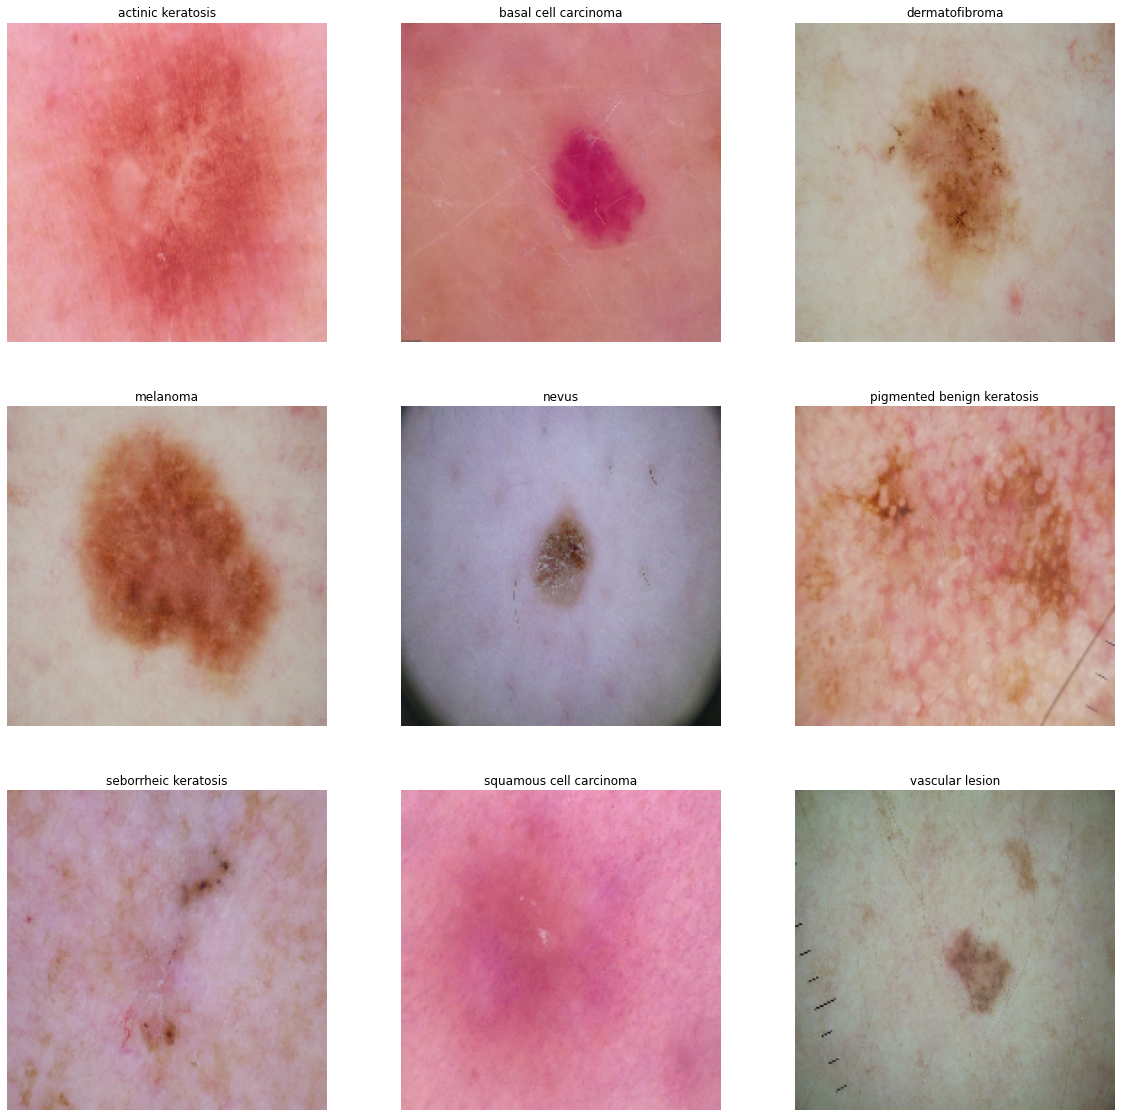

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")


  


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [85]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [86]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1).

In [87]:
normalization = layers.experimental.preprocessing.Rescaling(1./255)


In [88]:
normalized = train_ds.map(lambda x, y: (normalization(x), y))
image_batch, labels_batch = next(iter(normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.06274525 1.0


In [89]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
                    layers.Conv2D(16,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(64,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(128,activation='softmax'),
                    layers.Dense(num_classes)])

### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [90]:
### Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
# Viewing the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [92]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 10s 58ms/step - loss: 2.1843 - accuracy: 0.1350 - val_loss: 2.1893 - val_accuracy: 0.1403
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 2.1776 - accuracy: 0.1434 - val_loss: 2.1878 - val_accuracy: 0.1403
Epoch 3/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1764 - accuracy: 0.1434 - val_loss: 2.1880 - val_accuracy: 0.1403
Epoch 4/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1760 - accuracy: 0.1434 - val_loss: 2.1883 - val_accuracy: 0.1403
Epoch 5/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1761 - accuracy: 0.1434 - val_loss: 2.1886 - val_accuracy: 0.1403
Epoch 6/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1760 - accuracy: 0.1434 - val_loss: 2.1881 - val_accuracy: 0.1403
Epoch 7/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1760 - accuracy: 0.1434 - val_loss: 2.1880 - val_accuracy: 0.140

### Visualizing training results

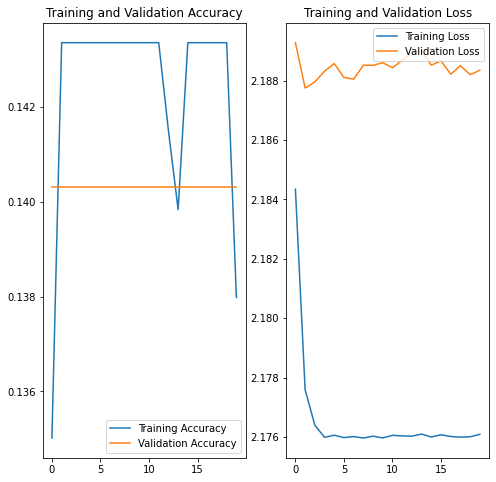

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h3 style = "color : Brown">

Inference:- From the above plots, we can infer that the training accuracy is increasing. It remained flat at an instance and became saturated. The validation accuracy is also flat. This means that the model overfitted
    
</h1>

In [94]:
# Choosing appropriate data augumentation strategy

dataaugmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
                                     layers.experimental.preprocessing.RandomRotation(0.1,interpolation='bilinear'),
                                     layers.experimental.preprocessing.RandomZoom(0.1,interpolation='bilinear')])

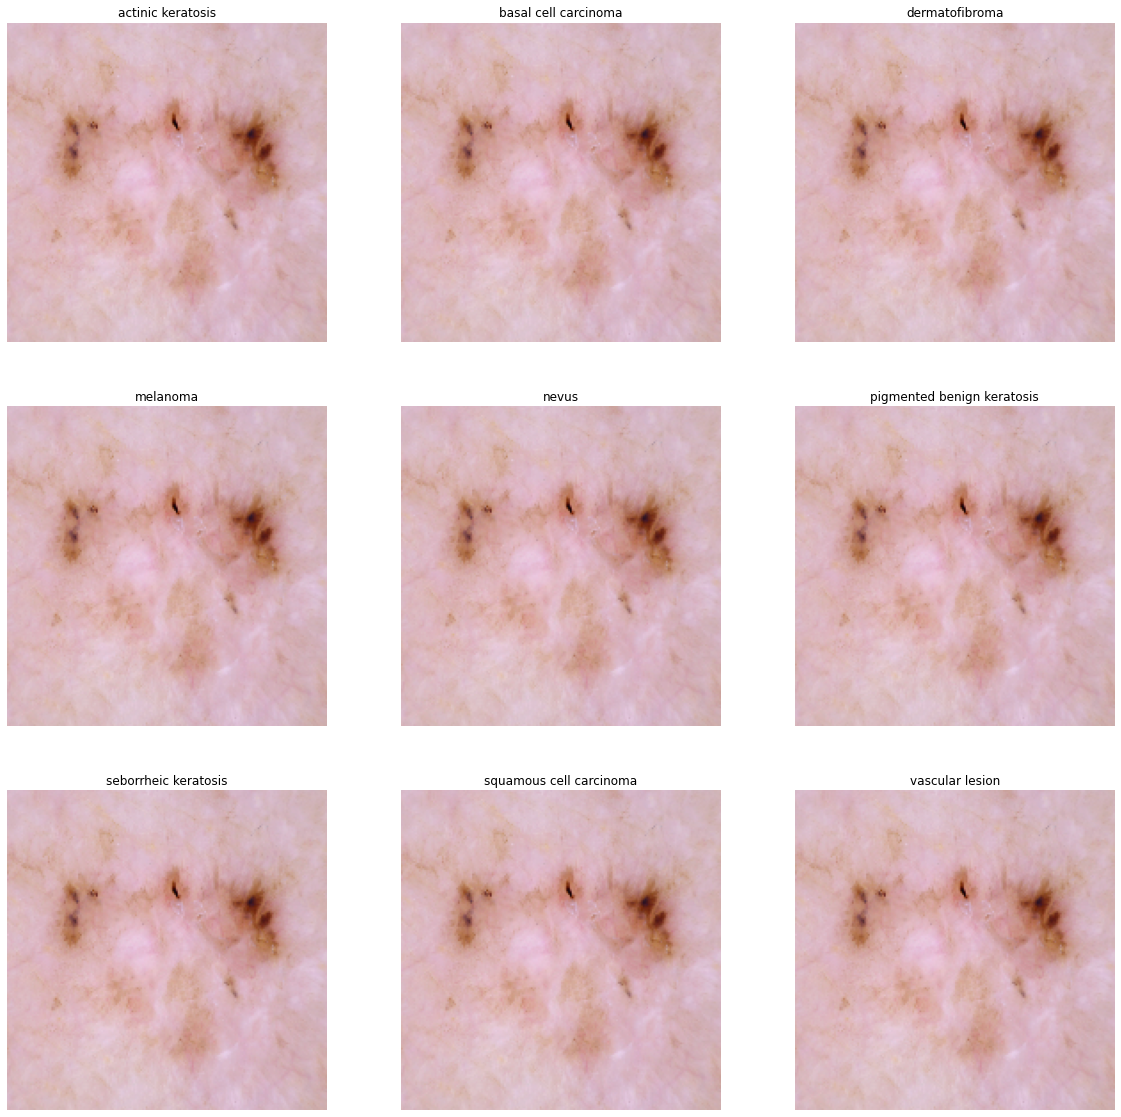

In [95]:
# Visualising how augmentation strategy works for one instance of training image.

plt.figure(figsize=(20,20))
for images,_ in train_ds.take(1):
  for i in range(9):
    aug_images = dataaugmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(aug_images[0].numpy().astype('uint8'))
    plt.title(class_names[i])
    plt.axis("off")

### Create the model, compile and train the model


In [96]:
## Using Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([dataaugmentation,
                    layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32,kernel_size=(3,3),padding='same',strides=(1,1),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(64,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128,activation='softmax'),
                    layers.Dense(num_classes)])


### Compiling the model

In [97]:

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [99]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
169/169 [==============================] - 5s 25ms/step - loss: 2.1839 - accuracy: 0.1380 - val_loss: 2.1846 - val_accuracy: 0.1403
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 2.1801 - accuracy: 0.1384 - val_loss: 2.1849 - val_accuracy: 0.1403
Epoch 3/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1766 - accuracy: 0.1434 - val_loss: 2.1865 - val_accuracy: 0.1403
Epoch 4/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1762 - accuracy: 0.1434 - val_loss: 2.1872 - val_accuracy: 0.1403
Epoch 5/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1762 - accuracy: 0.1385 - val_loss: 2.1879 - val_accuracy: 0.1403
Epoch 6/20
169/169 [==============================] - 4s 23ms/step - loss: 2.1761 - accuracy: 0.1434 - val_loss: 2.1882 - val_accuracy: 0.1403
Epoch 7/20
169/169 [==============================] - 4s 25ms/step - loss: 2.1761 - accuracy: 0.1434 - val_loss: 2.1882 - val_accuracy: 0.1403

### Visualizing the results

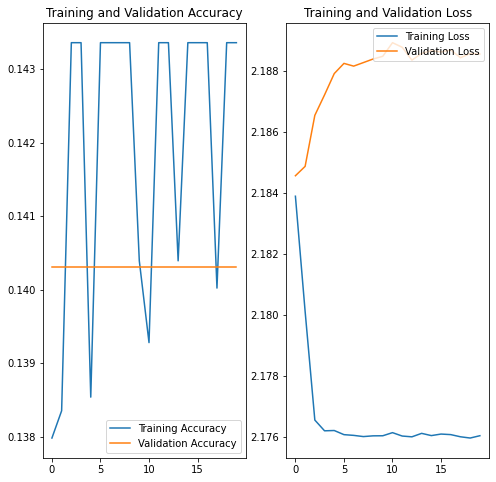

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Inference:-** There is some improvement in the model as compared to the previous model run as the training accuracy is lineraly increasing and the validation accuracy has come down near to the training accuracy

<h3 style = "color : Brown">
    
Finding the distribution of classes in the training dataset.

Context : Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.
    
</h3>

In [101]:
from glob import glob
list_of_path = [x for x in glob(os.path.join(data_dir_train,"*","*.jpg"))]
list_of_path

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0001103.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010754.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000553.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010797.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010783.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010608.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010393.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000144.jpg',
 '/content/drive/MyDrive/Skin ca

In [102]:
find_path = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,"*","*.jpg"))]
find_path

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [103]:
len(find_path)

2239

In [104]:
type(find_path)

list

In [105]:
original_dataframe = dict(zip(list_of_path,find_path))
original_dataframe

{'/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0001103.jpg': 'melanoma',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010754.jpg': 'melanoma',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000553.jpg': 'melanoma',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010797.jpg': 'melanoma',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010783.jpg': 'melanoma',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010608.jpg': 'melanoma',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010393.jpg': 'melanoma',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imag

In [106]:
df_original = pd.DataFrame(list(original_dataframe.items()),columns=["path","label"])
df_original.head()

,path,label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma
1,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma
2,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma
3,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma
4,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma


In [107]:
df_original.shape

(2239, 2)

In [108]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df_original['skin_labels'] = labelencoder.fit_transform(df_original['label'])
df_original

,path,label,skin_labels
0,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
1,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
2,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
3,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
4,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
5,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
6,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
7,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
8,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3
9,/content/drive/MyDrive/Skin cancer ISIC The In...,melanoma,3


In [109]:
import seaborn as sns

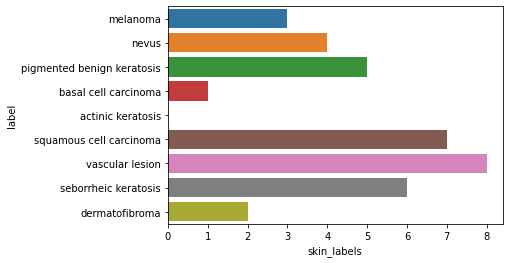

In [110]:
sns.barplot(y='label',x='skin_labels',data=df_original)
plt.show()

<h3 style = "color : Brown">
    
Findings
Which class has the least number of samples?
    
    Ans: Actinic keratosis has the least number of samples

Which classes dominate the data in terms proportionate number of samples?
    
    Ans: Vascular Lesion,Squamous cell carcinoma dominate the data in terms of proportionate number of samples
    
</h3>

In [111]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [112]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [113]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8E35294390>: 100%|██████████| 500/500 [00:23<00:00, 21.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8E353390D0>: 100%|██████████| 500/500 [00:22<00:00, 21.77 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8E361E2310>: 100%|██████████| 500/500 [00:22<00:00, 22.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F8EC0300050>: 100%|██████████| 500/500 [01:48<00:00,  4.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8E3524E750>: 100%|██████████| 500/500 [01:27<00:00,  5.69 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8E357C2F90>: 100%|██████████| 500/500 [00:20<00:00, 24.72 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8E35A13CD0>: 100%|██████████| 500/500 [00:45<00:00, 11.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8E361D5710>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8E361F2A90>: 100%|██████████| 500/500 [00:19<00:00, 25.56 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [114]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Seeing the distribution of augmented data after adding new images to the original training data.

In [115]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011052.jpg_499b4694-d96c-4f1f-9573-f865580fe646.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010655.jpg_635c2891-8421-4a77-8479-45c5c2e93a32.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010388.jpg_12008385-d6ac-4e37-bba9-6334ddf02be8.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000549.jpg_c22afe01-2d98-495e-8b29-f3c61bde54dc.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000172.jpg_62f18a19-68ce-4d21-a409-8b512aa24e90.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin 

In [116]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [117]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [118]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df_original.append(df2)

In [119]:
new_df['Label'].value_counts()

melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
basal cell carcinoma          1000
actinic keratosis             1000
squamous cell carcinoma       1000
vascular lesion               1000
seborrheic keratosis          1000
dermatofibroma                1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor






In [120]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [121]:
data_dir_train = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset

In [122]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [123]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [124]:
normalized_1 = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_1))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96486896


In [125]:
num_classes = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255),
                    layers.Conv2D(16,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu',input_shape=(img_height,img_width,3)),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(32,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(64,kernel_size=(3,3),padding='same',strides=(2,2),activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128,activation='softmax'),
                    layers.Dense(num_classes)])

#### Compiling  model

In [126]:

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [70]:
epochs = 50
## USING 50 epochs.
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/50
169/169 [==============================] - 30s 167ms/step - loss: 2.1742 - accuracy: 0.1558 - val_loss: 2.1479 - val_accuracy: 0.1863
Epoch 2/50
169/169 [==============================] - 30s 170ms/step - loss: 2.1106 - accuracy: 0.2188 - val_loss: 2.1235 - val_accuracy: 0.1789
Epoch 3/50
169/169 [==============================] - 29s 164ms/step - loss: 2.0423 - accuracy: 0.2307 - val_loss: 2.0174 - val_accuracy: 0.2287
Epoch 4/50
169/169 [==============================] - 29s 163ms/step - loss: 1.9912 - accuracy: 0.2413 - val_loss: 1.9871 - val_accuracy: 0.2242
Epoch 5/50
169/169 [==============================] - 28s 163ms/step - loss: 1.9575 - accuracy: 0.2450 - val_loss: 1.9737 - val_accuracy: 0.2168
Epoch 6/50
169/169 [==============================] - 29s 165ms/step - loss: 1.9277 - accuracy: 0.2493 - val_loss: 1.9268 - val_accuracy: 0.2264
Epoch 7/50
169/169 [==============================] - 29s 165ms/step - loss: 1.9044 - accuracy: 0.2493 - val_loss: 1.8955 - val_ac

#### Visualising the model results

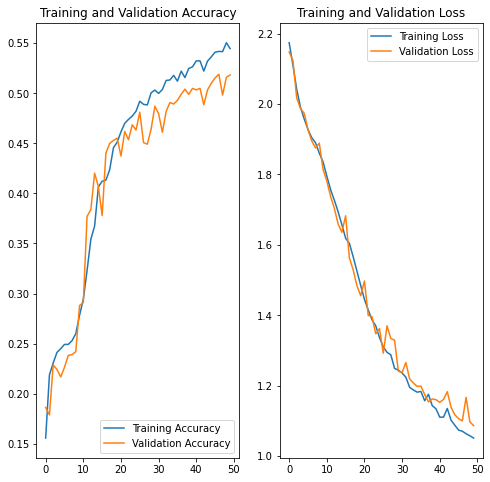

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h3 style = "color : Brown">

The plots infer that the model has improved, we have overcome the problem of overfitting and the class rebalance helped the model to perform better and to achieve better accuracy.
    
    Hence, the latest model can be considered as a good model
    
</h3>